In [ ]:
import pandas as pd

from sqlalchemy import create_engine, text

import matplotlib.pyplot as plt

import time 

In [9]:
def getTimestamp():
    return pd.Timestamp.now().strftime("%Y-%m-%d %H-%M-%S")

In [43]:
blue_path = f'..\\data_repo\\Blue\client_list'
gold_path = f'..\\data_repo\\Gold\\client_list\\'

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\paxm\AppData\Local\Temp\ipykernel_35464\1140701867.py:1: SyntaxWarning: invalid escape sequence '\c'
  blue_path = f'..\\data_repo\\Blue\client_list'


In [ ]:

# Loading stats report
# Stats report contains client and their activity count for each service/Feature of the V10 they use
# 

stats_report_file_df = pd.read_csv(f'..\\data_repo\\landing_zone\\stats_report\\monthly_reports\\DealerUsageReport_April_25.csv')



Things to do on teh dataset


- Identify the goal of the report 
- Identify key metrics that are being measured
- Identify the data that provides 
- Identify data transformations that need to be performed for efficient reporting
- 

#### Creating client list

- Create a dimensional client list from Stats report
- Save the table into a csv file that will be used for powerBi

In [ ]:
# As a normalization technique, from the stats report, create a list of all client list to work as a dimension table
# Save it as a table to 
# This will be maintained by adding more clients to the table periodically

def create_client_list_df(stats_report_file_df):

    # slice the report to pick columns that identify clients 
    tbl_clients = stats_report_file_df[['Serial','Name', 'DBA']]
    

    return tbl_clients

client_dimtbl =  create_client_list_df(stats_report_file_df)

In [48]:

def save_df_to_csv(df : pd.DataFrame, path, filename):
    if len(df)<0:
        print("File has not content, not sure you want to save it")
        return 
    
    df.to_csv(f'{path}{filename}_{getTimestamp()}.csv', index=False)



In [ ]:
# Saving a new final client list to the gold stage, ready for analytics

save_df_to_csv(client_dimtbl, gold_path, "clientsDimtbl")



In [ ]:
# Normalization: 
# create a client df that will store all client information. Serial #, client name, and DBA
# Create a fact fact table that has serial number, deployment ID, and all the usage information

client_df = stats_report_file_df[['Serial', 'Name', 'DBA']].drop_duplicates().reset_index(drop=True)
client_df.columns = ['Serial', 'ClientName', 'DBA']

In [ ]:
# Create a fact table that has serial number, deployment ID, and all the usage information
user_activity_df = stats_report_file_df.drop(columns=['Name', 'DBA']).reset_index(drop=True)


## 1. the Goal

- Create an improved report using PowerBI to offer insight on user activity for the OEM Accessory feature
- Identify key metrics that are useful for product tracking 
    - Top ten client using the product often
    - Top users per client
    
    - Average daily usage per user (will need to filter for client with the feature enabled)
    - Average usage per user position 
    - 

- 


### Direct DB Connection

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv(dotenv_path="creds\\.env")

True

In [ ]:

def establish_db_connetion(server, database, username, password, driver):
    connection_string = (
        f"mssql+pyodbc://{username}:{password}@{server}/{database}"
        f"?driver={driver.replace(' ', '+')}"
    )
    engine = create_engine(connection_string)

    try:
        with engine.connect() as conn:
            result = conn.execute(text("SELECT @@VERSION"))
            for row in result:
                print("Connected successfully. SQL Server version:")
                print(row[0])
            return engine
    except Exception as e:
        print("Connection failed:")
        print(e)
        return None



# Adjust to include error handling for the db connection method



In [ ]:
%pip install pyodbc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:

load_dotenv(dotenv_path="creds\\.env")

db_156 = establish_db_connetion(
    os.getenv('SERVER_dev_test05'),
    os.getenv('DB_156Evolution'), 
    os.getenv('USER_NAME'),     
    os.getenv('PASSWORD_dev-test'),
    os.getenv("ODBC_DRIVER")
)
 

Connected successfully. SQL Server version:
Microsoft SQL Server 2022 (RTM-CU15-GDR) (KB5046862) - 16.0.4155.4 (X64) 
	Oct 18 2024 16:16:11 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows Server 2022 Standard 10.0 <X64> (Build 20348: )



In [ ]:
get_all_tbls_db156 = "SELECT TOP 10 * FROM Parts_tblSources"
all_db_tables = pd.read_sql(get_all_tbls_db156, db_156)


In [ ]:
print  (os.getenv('pbsaristo_SERVER'),
    os.getenv('DB_StatsAgent'), 
    os.getenv('USER_NAME'),     
    os.getenv('PASSWORD_Aristo'),
    os.getenv("ODBC_DRIVER"))

pbsaristo.database.windows.net pbsStatsAgent pbsuser pbs8805! ODBC Driver 17 for SQL Server


In [ ]:
tbl_statsAnget_Engine = establish_db_connetion(
    os.getenv('pbsaristo_SERVER'),
    os.getenv('DB_StatsAgent'), 
    os.getenv('USER_NAME'),     
    os.getenv('PASSWORD_Aristo'),
    os.getenv("ODBC_DRIVER")
)

Connected successfully. SQL Server version:
Microsoft SQL Azure (RTM) - 12.0.2000.8 
	Apr  9 2025 07:13:50 
	Copyright (C) 2024 Microsoft Corporation



In [ ]:

query = "SELECT * FROM dbo.tblActivityLog WHERE fldKey = 'Deal.Accessories.OEM'"
tbl_activityLog = pd.read_sql(query, tbl_statsAnget_Engine)
print(tbl_activityLog.head())


       fldId fldSerialNumber     fldDate  fldUserRef                fldKey  \
0  170509361            7415  2025-01-01        1031  Deal.Accessories.OEM   
1  170806930            7831  2025-01-02         273  Deal.Accessories.OEM   
2  170858122            5234  2025-01-02         439  Deal.Accessories.OEM   
3  170858724            5235  2025-01-02         511  Deal.Accessories.OEM   
4  170858796            5235  2025-01-02         522  Deal.Accessories.OEM   

   fldCount  
0         1  
1         1  
2         2  
3         3  
4         1  


In [ ]:
tbl_activityLog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fldId            1823 non-null   int64 
 1   fldSerialNumber  1823 non-null   object
 2   fldDate          1823 non-null   object
 3   fldUserRef       1823 non-null   int64 
 4   fldKey           1823 non-null   object
 5   fldCount         1823 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 85.6+ KB


In [ ]:
df = tbl_activityLog.copy()

#### Dataset cleanup  

- Drop all records with 
- Serial number contains non-numeric values (Removes QA serial Numbers (.QA), and Null)
 


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fldId            1823 non-null   int64 
 1   fldSerialNumber  1823 non-null   object
 2   fldDate          1823 non-null   object
 3   fldUserRef       1823 non-null   int64 
 4   fldKey           1823 non-null   object
 5   fldCount         1823 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 85.6+ KB


In [ ]:
# find how many serial number have non-numeric values in Serial field

def find_non_numeric_serial_numbers(df):
    non_numeric_serials = len(df[~df['fldSerialNumber'].str.isnumeric()]['fldSerialNumber'].unique().tolist())
    print("This dataframe has", non_numeric_serials, "non-numeric serial numbers.\n")
    if non_numeric_serials > 0:
        print("These are the non-numeric serial numbers:\n")
        print(df[~df['fldSerialNumber'].str.isnumeric()]['fldSerialNumber'].unique())
        return
    print("All serial numbers are numeric.")

    return 


In [ ]:
# remove all non-numeric serial numbers from the dataframe

def remove_non_numeric_serial_numbers(df):
    df = df[df['fldSerialNumber'].str.isnumeric()]
    print("The dataframe has been cleaned of non-numeric serial numbers.")
    return df

In [ ]:

# Method to decompose a date field into Year, Month, Day, and Day_of_week

def decompose_date_field(df, date_field):
    df[date_field] = pd.to_datetime(df[date_field], errors='coerce')
    df['Year'] = df[date_field].dt.year
    df['Month'] = df[date_field].dt.month
    df['Day'] = df[date_field].dt.day
    df["Day_of_week"] = df[date_field].dt.day_name()
    return df

## Loading Stats Agent data

In [ ]:


def clean_df(df):
    find_non_numeric_serial_numbers(df)
    df = remove_non_numeric_serial_numbers(df)

    df = decompose_date_field(df, "fldDate") 
    return df

df = clean_df(df)



This dataframe has 5 non-numeric serial numbers.

These are the non-numeric serial numbers:

['3169.QA' '5614.QA' '3184.QA' '3183.QA' '7718.QA']
The dataframe has been cleaned of non-numeric serial numbers.


C:\Users\paxm\AppData\Local\Temp\ipykernel_7372\2707022986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_field] = pd.to_datetime(df[date_field], errors='coerce')
C:\Users\paxm\AppData\Local\Temp\ipykernel_7372\2707022986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df[date_field].dt.year
C:\Users\paxm\AppData\Local\Temp\ipykernel_7372\2707022986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

<Axes: title={'center': 'Monthly Activity Log Counts'}, xlabel='Month'>

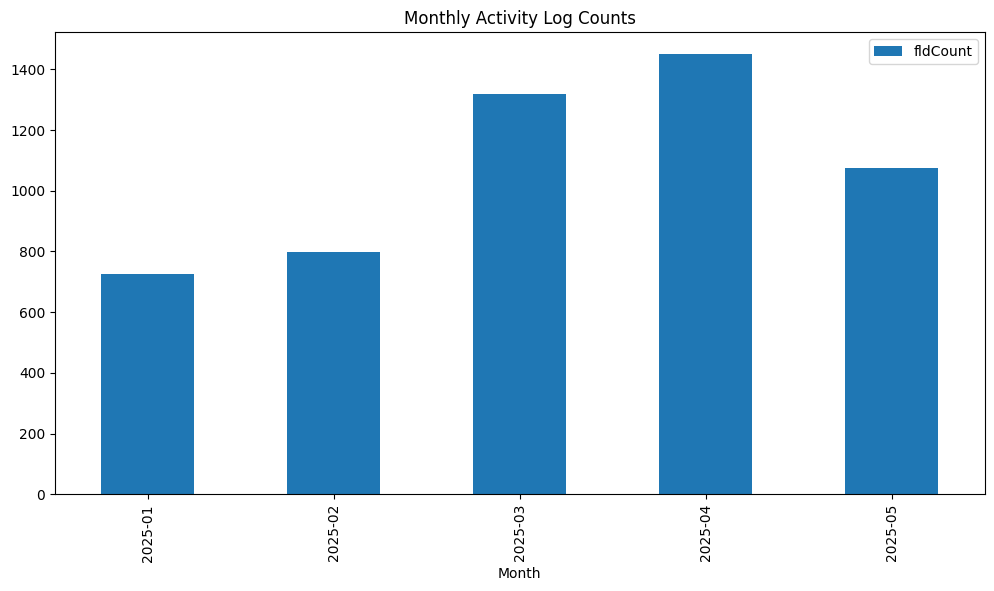

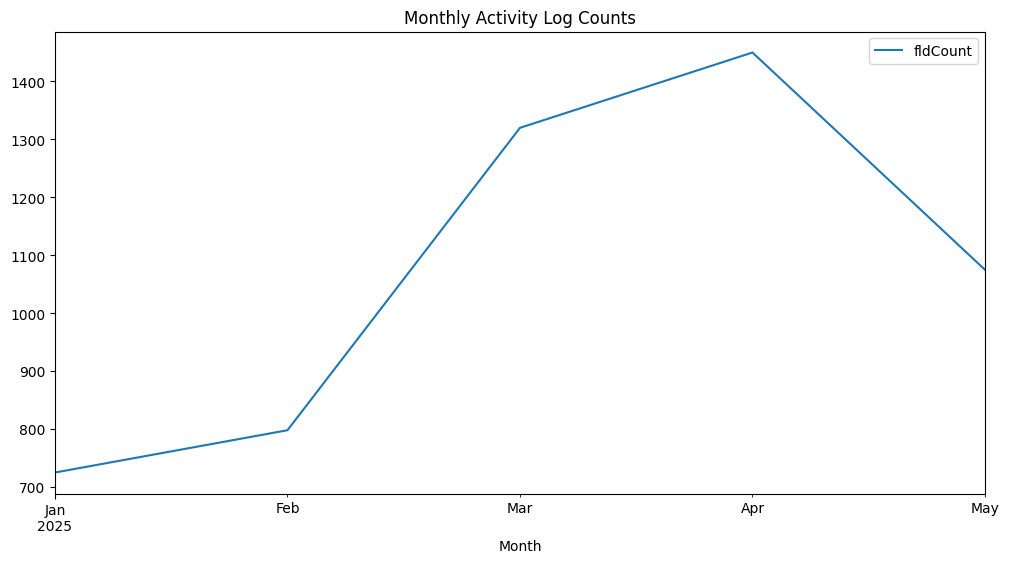

In [ ]:

# Group by fldDate by month of year and plot the sum of fldCount for each month?
df['fldDate'] = pd.to_datetime(df['fldDate'])
df['Month'] = df['fldDate'].dt.to_period('M')
monthly_counts = df.groupby('Month')['fldCount'].sum().reset_index()
monthly_counts.plot(x='Month', y='fldCount', kind='bar', figsize=(12, 6), title='Monthly Activity Log Counts')


# change this graph to a line graph
monthly_counts.plot(x='Month', y='fldCount', kind='line', figsize=(12, 6), title='Monthly Activity Log Counts')


<Axes: title={'center': 'Daily Activity Log Counts by Day of Week'}, xlabel='DayOfWeek'>

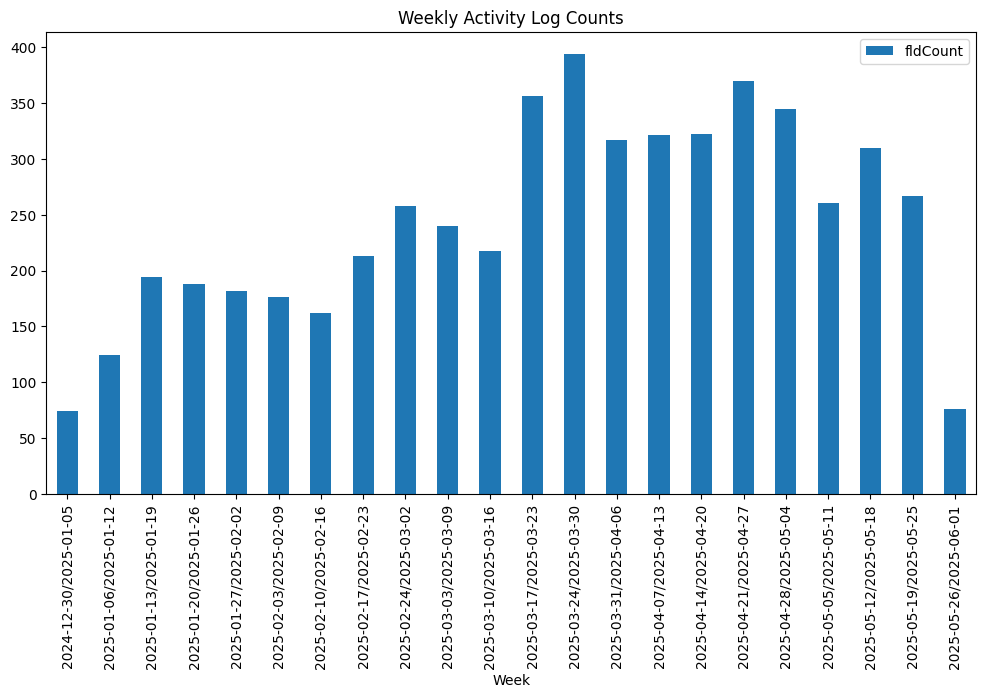

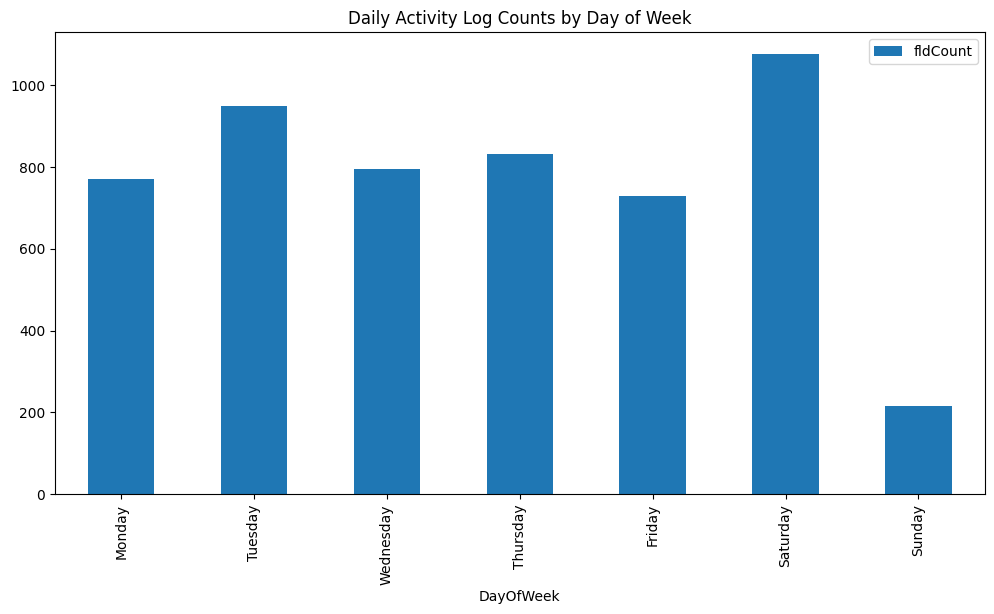

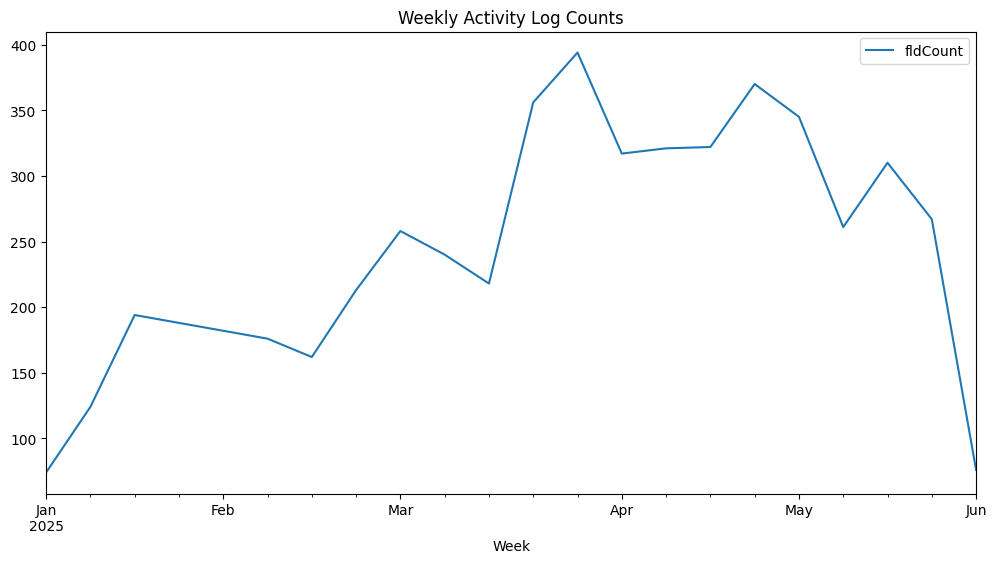

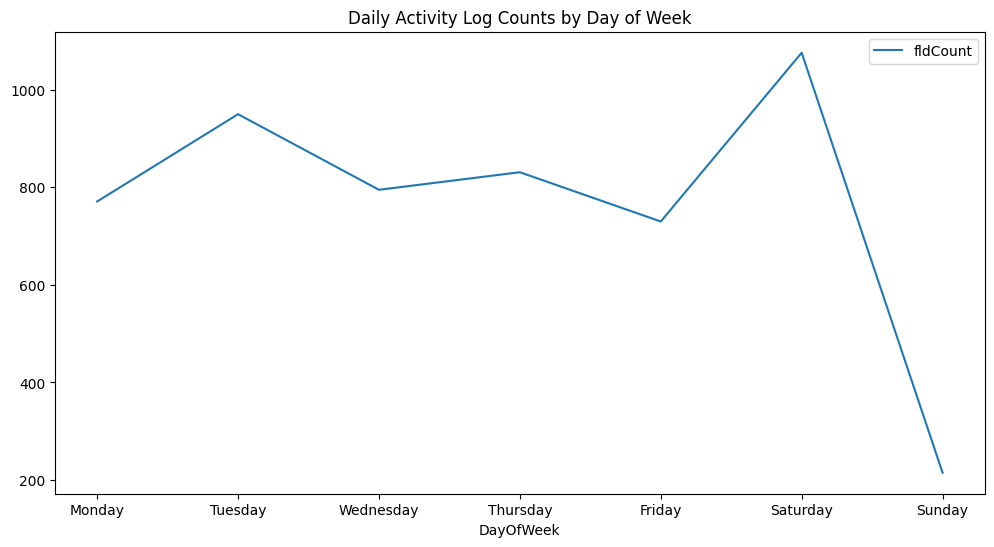

In [ ]:
# Show sum of fldcount by week of month 
df['Week'] = df['fldDate'].dt.to_period('W')
weekly_counts = df.groupby('Week')['fldCount'].sum().reset_index()
# weekly_counts['Week'] = weekly_counts['Week'].dt.to_timestamp()
weekly_counts.plot(x='Week', y='fldCount', kind='bar', figsize=(12, 6), title='Weekly Activity Log Counts')


# Show sum of fldcount by day of week
df['DayOfWeek'] = df['fldDate'].dt.day_name()
daily_counts = df.groupby('DayOfWeek')['fldCount'].sum().reset_index()
daily_counts = daily_counts.sort_values('DayOfWeek', key=lambda x: pd.Categorical(x, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True))
daily_counts.plot(x='DayOfWeek', y='fldCount', kind='bar', figsize=(12, 6), title='Daily Activity Log Counts by Day of Week')



# Change these graphs to line graphs

weekly_counts.plot(x='Week', y='fldCount', kind='line', figsize=(12, 6), title='Weekly Activity Log Counts')
daily_counts.plot(x='DayOfWeek', y='fldCount', kind='line', figsize=(12, 6), title='Daily Activity Log Counts by Day of Week')



In [ ]:
from datetime import datetime

In [ ]:
date_format= "%Y-%m-%d"
date_obj = datetime.strptime("2025-05-27", "%Y-%m-%d")
print(date_obj.isocalendar().week)




22


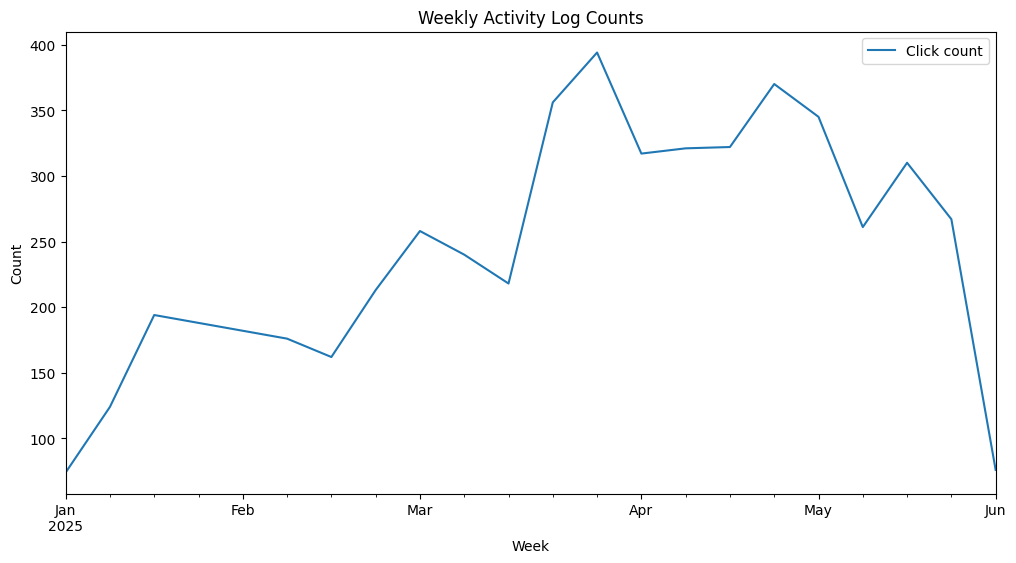

In [ ]:
# Total number of click by months

weekly_count_plt = weekly_counts.plot(
    x='Week', 
    y='fldCount', 
    kind='line', 
    figsize=(12, 6),
    legend = False, 
    title='Weekly Activity Log Counts')


# Set y-axis label
weekly_count_plt.set_ylabel('Count')

# Set custom legend
weekly_count_plt.legend(['Click count'])



# for x, y in zip(weekly_counts['Week'], weekly_counts['fldCount']):
#     weekly_count_plt.annotate(
#     str(y),
#     xy=(x, y),
#     xytext=(0, 5),
#     textcoords='offset points',
#     ha='center',
#     va='bottom',
#     color='red'
#     )

# Show the plot
plt.show()




In [ ]:
# Overall Daily visit/click 

# Sum of fldCount/ (len(df))
print("Overall Average Daily visit/click:", round(df["fldCount"].sum()/len(df), 2))



Overall Average Daily visit/click: 2.97


In [ ]:
# Top 10 client with most usage


top_10_clients =  (
    df.groupby("fldSerialNumber")["fldCount"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns= {"fldCount": "Total count"}).head(10)  
    )

top_10_clients


,fldSerialNumber,Total count
0,7415,1294
1,5234,1148
2,5235,660
3,3169,590
4,3179,264
5,7717,232
6,5622,230
7,7831,129
8,7070,126
9,5644,109


In [ ]:

# What's the daily average user activity on the feature
# Average daily activity count for active users
#  